# Sistema de Recomendação

Este notebook apresenta algumas implementações de sistema de recomendação utilizando
o dataset Movielens.
Este notebook contém:
- Modelo de Sistema de Recomendação utilizando atributos latentes e produto interno
- Modelo utilizando atributos latentes concatenados e uma rede neural
- Calcula a predição para todos os filmes e usuários que não fizeram suas avaliações
- Visualiza a matriz de avaliações por usuários x filmes com todas as predições
- Análise do significado dos embeddings

Obs: Este notebook foi inspirado em exemplo divulgado pelo curso online disponível em [fast.ai](http://fast.ai)

## Importação da bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import os, sys
import pandas as pd

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [18]:
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Movielens dataset

- [Movielens - Readme](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)
- Movielens - Small data set - 100.000 avaliações:[ml-latest-small.zip](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015).


### Leitura dos Dados - Movielens dataset

Caso a célula a seguir falhar, é necessário executar o notebook:
- [Movielens Dataset](MovieLens_dataset_pytorch.ipynb) que é responsável por ler o dataset original e
prepará-lo para este notebook

Este dataset consiste de:
- 100.004 avaliações de filmes (amostras), feitas por
- 671 usuários, sobre
- 9066 filmes

As amostras estão no array `ratings` organizados da seguinte forma:
- cada linha é uma amostra
- coluna 0 é o iD do usuário
- coluna 1 é o iD do filme
- coluna 2 é a avaliação do usuários entre 0.0 e 5.0

In [4]:
data = np.load('../data/movielens_norm.npz')
ratings     = data['ratings']
movie_names = data['movie_names']
n_samples   = ratings.shape[0]
print('n_samples:',n_samples)
print('ratings:\n', ratings[:5])

n_samples: 100004
ratings:
 [[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]]


In [5]:
for i in (ratings[:5,1]).astype(np.int):
    print(movie_names[i])

Dangerous Minds (1995)
Dumbo (1941)
Sleepers (1996)
Escape from New York (1981)
Cinema Paradiso (Nuovo cinema Paradiso) (1989)


In [6]:
h_userId  = np.bincount(ratings[:,0].astype(np.int))
n_users   = h_userId.size
h_movieId = np.bincount(ratings[:,1].astype(np.int))
n_movies  = h_movieId.size
print('n_users:',n_users)
print('n_movies:',n_movies)

n_users: 671
n_movies: 9066


## Divisão dos dados em treinamento e validação

In [7]:
np.random.seed = 42

Faz a divisão com 80% das amostras para treinamento e 20% para validação:

In [8]:
msk = np.random.rand(n_samples) < 0.8
train = ratings[msk]
valid = ratings[~msk]
print('train:',train.shape[0],' amostras:\n',train[:5])
print('valid:',valid.shape[0],' amostras:\n',valid[:5])

train: 80051  amostras:
 [[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  1017.0  2.0]]
valid: 19953  amostras:
 [[ 0.0  931.0  4.0]
 [ 1.0  123.0  3.0]
 [ 1.0  144.0  3.0]
 [ 1.0  164.0  3.0]
 [ 1.0  198.0  3.0]]


`userId` e `movieId` precisam ser inteiros pois são entradas do *Embedding*:

In [9]:
train_userId  = torch.LongTensor(train[:,0].astype(np.int))
train_movieId = torch.LongTensor(train[:,1].astype(np.int))
train_ratings = torch.FloatTensor(train[:,2:3]) # importante que fique bidimensional
valid_userId  = torch.LongTensor(valid[:,0].astype(np.int))
valid_movieId = torch.LongTensor(valid[:,1].astype(np.int))
valid_ratings = torch.FloatTensor(valid[:,2:3]) # importante que fique bidimensional

## Definição da classe MLDataset

In [10]:
from torch.utils.data import Dataset
class MLDataset(Dataset):
    
    def __init__(self, data_user, data_movie, target):
        assert data_user.size(0)  == target.size(0) and \
               data_movie.size(0) == target.size(0)
        
        self.data   = torch.transpose(torch.stack( (data_user, data_movie) ),0,1)
        self.target = target
    
    def __len__(self):
        return self.target.size(0)
    
    def __getitem__(self, i):
        return (self.data[i], self.target[i])

### Criação dos objetos datasets e dataloaders

In [11]:
datasets = {
    'train': MLDataset(train_userId, train_movieId, train_ratings),
    'val'  : MLDataset(valid_userId, valid_movieId, valid_ratings)
    }

dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=64, shuffle=True),
    'val'  : torch.utils.data.DataLoader(datasets['val'],   batch_size=64, shuffle=True)
    }

dataset_sizes = {
    'train': len(datasets['train']),
    'val'  : len(datasets['val'])
    }

print(dataset_sizes)

{'train': 80051, 'val': 19953}


### Testando os datasets

In [12]:
x, y = datasets['train'][3:5]
print(x)
print(y)


    0   906
    0  1017
[torch.LongTensor of size 2x2]


 2
 2
[torch.FloatTensor of size 2x1]



### Testando os dataloaders

In [13]:
batch_size = 64
print( len(dataloaders['val']) * batch_size ) # verificando mini-batches
for k,data in enumerate(dataloaders['val']):
    print(k, len(data[0]), len(data[1]))
    if k > 1: break

19968
0 64 64
1 64 64
2 64 64


## Primeira solução - usando produto interno: Dot

<img src='../figures/Recomendacao_dot.png', width=600ptx></img>

O primeiro modelo é o produto interno entre os atributos latentes dos usuários e dos filmes.
Este produto interno é implementado pelo produto elemento por elemento das matrizes
de atributos dos usuários e dos filmes e posteriormente somado, resultado um valor escalar por amostra:

In [14]:
class DotNet(nn.Module):
    def __init__(self, n_users, n_movies, n_attributes):
        """
        No construtor, criamos as duas embeddings, uma para os usuários e 
        outra para os filmes.
        """
        super(DotNet, self).__init__()
        self.user_emb  = nn.Embedding(n_users, n_attributes)
        nn.init.xavier_uniform(self.user_emb.weight)
        self.movie_emb = nn.Embedding(n_movies, n_attributes)
        nn.init.xavier_uniform(self.movie_emb.weight)

    def forward(self, x):
        """
        x: (user_id, movie_id)
        """
        user_id  = x[:,0]
        movie_id = x[:,1]
        user_attr  = self.user_emb(user_id)
        movie_attr = self.movie_emb(movie_id)
        y_pred = (user_attr * movie_attr).sum(1)
        return y_pred


### Instanciando a rede

In [15]:
n_factors = 50
model_dot = DotNet(n_users, n_movies, n_factors)
if use_gpu:
    model_dot.cuda()
model_dot

DotNet (
  (user_emb): Embedding(671, 50)
  (movie_emb): Embedding(9066, 50)
)

### Testando o predict e o loss da rede com poucos dados e sem treinar

In [16]:
criterion = nn.MSELoss(size_average=True)
data_um = torch.transpose(torch.stack( (train_userId[0:3],train_movieId[0:3]) ),1,0)
print(data_um)
if use_gpu:
    data_um = data_um.cuda()
    train_ratings = train_ratings.cuda()
y_pred = model_dot(Variable(data_um))
print(y_pred)
loss = criterion(y_pred, Variable(train_ratings[0:3]))
print(loss)


   0   30
   0  833
   0  859
[torch.LongTensor of size 3x2]

Variable containing:
1.00000e-03 *
  3.1986
 -5.8645
 -0.7516
[torch.FloatTensor of size 3]

Variable containing:
 8.0913
[torch.FloatTensor of size 1]



### Testando o predict e loss com dataset

In [17]:
x,y = datasets['train'][3:4]
if use_gpu:
    x = x.cuda()
    y = y.cuda()
print(x)
print(y)
y_pred = model_dot(Variable(x))
print(y_pred)
loss = criterion(y_pred, Variable(y))
print(loss)


   0  906
[torch.LongTensor of size 1x2]


 2
[torch.FloatTensor of size 1x1]

Variable containing:
1.00000e-04 *
 -3.1340
[torch.FloatTensor of size 1]

Variable containing:
 4.0013
[torch.FloatTensor of size 1]



### Testando o predict e o dataset

### Treinando a rede

In [19]:
optimizer = torch.optim.Adam(model_dot.parameters())
savebest  = ptt.ModelCheckpoint('../../models/Recomendacao_dot', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(
    model         = model_dot, 
    criterion     = nn.MSELoss(), 
    optimizer     = torch.optim.Adam(model_dot.parameters()), 
    callbacks     = [savebest, ptt.PrintCallback()]
                     )

In [23]:
trainer.fit_loader(n_epochs=8, train_data=dataloaders['train'], valid_data=dataloaders['val'])

Start training for 8 epochs
  1:  14.6s   T: 10.74859   V: 4.36180 best
  2:  20.6s   T: 2.44492   V: 1.84030 best
  3:  21.2s   T: 1.22490   V: 1.42620 best
  4:  20.8s   T: 0.89374   V: 1.29991 best
  5:  20.7s   T: 0.73809   V: 1.25509 best
  6:  21.3s   T: 0.63915   V: 1.23962 best
  7:  21.0s   T: 0.56455   V: 1.23413 best
  8:  21.0s   T: 0.50339   V: 1.23892 
Best model was saved at epoch 7 with loss 1.23413: ../../models/Recomendacao_dot
Stop training at epoch: 8/8


### Avaliando a rede

Ultima loss: 1.2389189201459272


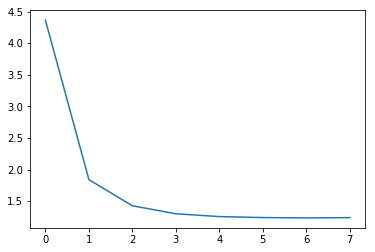

In [27]:
plt.plot(trainer.metrics['valid']['losses'])
print('Ultima loss:', trainer.metrics['valid']['losses'][-1])

Os bons modelos [best benchmarks](http://www.librec.net/example.html) são próximos de 0.9, há necessidade de melhorias.

### Predição de usuário e filme

Para calcular qualquer predição de qualquer usuário e qualquer filme, usa-se o `predict` do modelo treinado:

In [32]:
# user_id: 3 e movie_id: 6
trainer.predict(torch.LongTensor([[3, 6]]))


 3.9998
[torch.FloatTensor of size 1]

##  Usado Rede Neural

Uma solução usando rede neural é concatenar a saída dos embeddings e em seguida colocar uma camada densa
antes da última camada de um neurônio. No exemplo a seguir foi utilizado uma camada de 70 neurônios.

<img src='../figures/Recomendacao_NN.png', width=600ptx></img>

In [64]:
class RecommendNet(nn.Module):
    def __init__(self, n_users, n_movies, n_attributes):
        """
        No construtor, criamos as duas embeddings, uma para os usuários e 
        outra para os filmes e duas densas.
        """
        super(RecommendNet, self).__init__()
        self.user_emb  = nn.Embedding(n_users, n_attributes)
        nn.init.xavier_uniform(self.user_emb.weight)
        self.movie_emb = nn.Embedding(n_movies, n_attributes)
        nn.init.xavier_uniform(self.movie_emb.weight)
        self.dense1 = nn.Linear(2*n_attributes, 70)
        nn.init.xavier_uniform(self.dense1.weight, gain=nn.init.calculate_gain('relu'))
        self.dense2 = nn.Linear(70,1)
        nn.init.xavier_uniform(self.dense2.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x):
        """
        x: (user_id, movie_id)
        """
        user_id  = x[:,0]
        movie_id = x[:,1]
        user_attr  = self.user_emb(user_id)
        movie_attr = self.movie_emb(movie_id)
        x1 = torch.cat((user_attr,movie_attr),dim=1)
        x2 = nn.functional.dropout(x1,0.3)
        x3 = nn.functional.relu(self.dense1(x2))
        x4 = nn.functional.dropout(x3,0.75)
        y_pred = self.dense2(x4)
        return y_pred
    
    def get_movie_emb(self, movie_id):
        return self.movie_emb(movie_id)
    

In [67]:
model_net = RecommendNet(n_users, n_movies, n_factors)
if use_gpu:
    model_net = model_net.cuda()
model_net

RecommendNet (
  (user_emb): Embedding(671, 50)
  (movie_emb): Embedding(9066, 50)
  (dense1): Linear (100 -> 70)
  (dense2): Linear (70 -> 1)
)

## Treinando a rede

In [35]:
optimizer = torch.optim.Adam(model_net.parameters())
savebest  = ptt.ModelCheckpoint('../../models/Recomendacao_net', reset=True, verbose=1)

trainer_net = ptt.DeepNetTrainer(
    model         = model_net, 
    criterion     = nn.MSELoss(), 
    optimizer     = torch.optim.Adam(model_net.parameters()), 
    callbacks     = [savebest, ptt.PrintCallback()]
                     )

In [36]:
trainer_net.fit_loader(n_epochs=5, train_data=dataloaders['train'], valid_data=dataloaders['val'])

Start training for 8 epochs
  1:  15.2s   T: 1.40751   V: 0.81747 best
  2:  22.4s   T: 0.74826   V: 0.78707 best
  3:  22.5s   T: 0.69159   V: 0.78338 best
  4:  22.6s   T: 0.64093   V: 0.79178 
Best model was saved at epoch 3 with loss 0.78338: ../../models/Recomendacao_net
Stop training at epoch: 4/8


### Avaliando a rede

In [37]:
trainer_net.load_state('../../models/Recomendacao_net')
print(trainer_net.metrics['valid']['losses'][-1])

0.7833789065834968


Com esta rede, a perda já é bem melhor, comparável com os melhores sistemas de recomendação.

## Matriz de recomendações, por usuário e por filme

O sistema de recomendação pode ser visualizado por uma matriz onde as linhas sejam os
IDs dos usuários e as colunas sejam os IDs dos títulos dos filmes. Colocamos como -1
os elementos em que não existem avaliações. Esta matriz é bastante esparsa, pois existem
normalmente poucas avaliações feitas.

In [38]:
grid_ratings = -1. * np.ones((n_users,n_movies))
uId = (ratings[:,0]).astype(np.int)
mId = (ratings[:,1]).astype(np.int)
grid_ratings[uId,mId] = ratings[:,2] # Criação da matriz
print(grid_ratings.shape)

(671, 9066)


### Visualização da matriz de recomendações, original

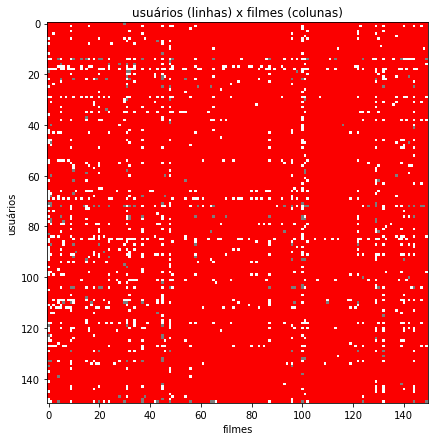

In [39]:
show_ratings = np.zeros((n_users,n_movies,3))
show_ratings[:,:,0] = np.where(grid_ratings == -1., 5, grid_ratings)
show_ratings[:,:,1] = np.where(grid_ratings == -1., 0., grid_ratings)
show_ratings[:,:,2] = np.where(grid_ratings == -1., 0., grid_ratings)


import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(show_ratings[:150,:150,:])
plt.xlabel('filmes')
plt.ylabel('usuários')
plt.show()

## Predições para todos os usuários e filmes

In [51]:
n2p_user,n2p_movie = np.nonzero(grid_ratings==-1)
xin = torch.from_numpy(np.array([n2p_user, n2p_movie]).T)
recommend = trainer_net.predict(xin)

### Montagem da matriz de recomendação "cheia"

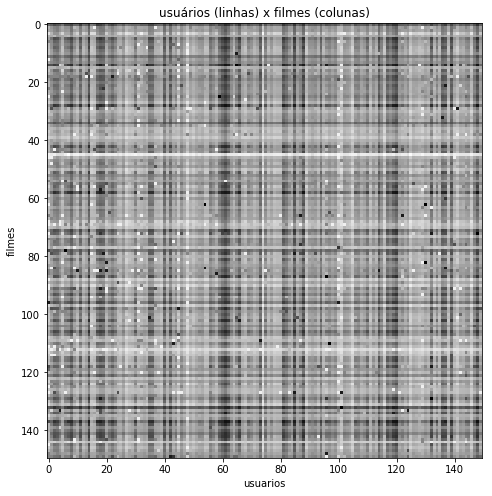

In [57]:
gg = grid_ratings.copy()
gg[n2p_user,n2p_movie] = recommend[:,0].numpy()

plt.figure(figsize=(8,8))
plt.title('usuários (linhas) x filmes (colunas)')
plt.xlabel('usuarios')
plt.ylabel('filmes')
plt.imshow(gg[:150,:150],cmap='gray')
plt.show()

### Visualização da parte de usuários mais ativos e filmes mais populares

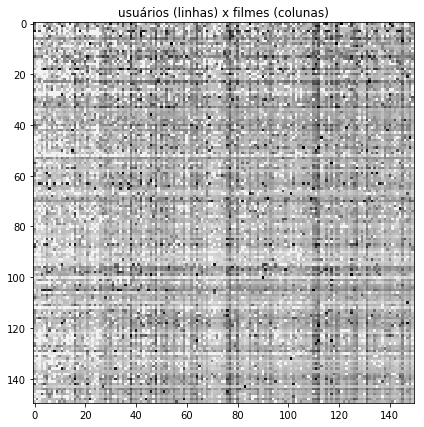

In [59]:
io_popular_movies = np.argsort(h_movieId)[::-1]
io_top_users = np.argsort(h_userId)[::-1].astype(np.int)
gg_ord = gg[np.ix_(io_top_users,io_popular_movies)]
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[:150,:150],cmap='gray')
plt.show()

### Visualização dos usuários menos ativos e filmes menos avaliados

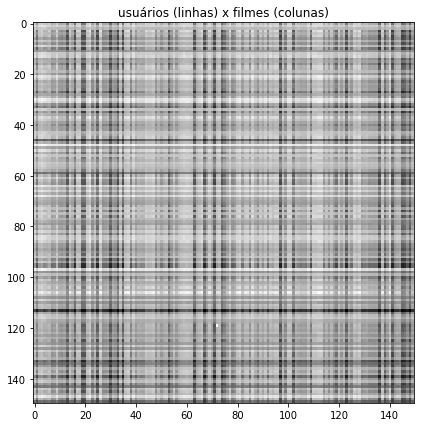

In [60]:
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[-150:,-150:],cmap='gray')
plt.show()

## Analise dos embeddings dos filmes

A análise a seguir será feita apenas com os 2000 filmes mais populares:

In [77]:
topMovies = io_popular_movies[:2000].copy()

### Extração dos atributos latentes (embeddings) dos 2000 fimes mais populares

Para obter os atributos latentes dos 2000 filmes mais populares, primeiro criamos uma
nova rede, denominada `get_movie_emb`, a partir da rede `Model`, com a entrada apenas o ID dos filmes e
a saída `m`, após o embedding. Aplicamos a predição desta rede nos `topMovies`:

In [84]:
m_emb = model_net.get_movie_emb(Variable(torch.unsqueeze(torch.LongTensor(topMovies),1))).data.numpy()

In [85]:
#get_movie_emb = Model(movie_in, m)
#m_emb = get_movie_emb.predict([topMovies])
movie_emb = np.squeeze(m_emb) # elimina dimensões 1
print(m_emb.shape)
movie_emb.shape

(2000, 1, 50)


(2000, 50)

Como o embedding de cada filme tem dimensão 50, é muito difícil conseguir analisá-lo desta forma.
Uma forma muito usual é reduzir esta dimensionalidade utilizando uma técnica denominada PCA -
Principal Component Analysis: [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/).
Iremos reduzir a dimensão dos embeddings de 50 para 3. 

In [86]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
movie_pca = pca.fit(movie_emb.T).components_

#### Filmes com alto valor na primeira dimensão do PCA

In [87]:
fac0 = movie_pca[0]
isort = np.argsort(fac0)[::-1]

for ii in isort[:15]:
    print(fac0[ii],movie_names[ii])

0.0650372 Storefront Hitchcock (1997)
0.063213 Bad Moon (1996)
0.0594491 To Gillian on Her 37th Birthday (1996)
0.056682 As Good as It Gets (1997)
0.0565749 Heart Condition (1990)
0.056123 Love and Other Catastrophes (1996)
0.0557682 Red Corner (1997)
0.0552731 Carmen Miranda: Bananas Is My Business (1994)
0.0542043 Aliens (1986)
0.0536154 Big Lebowski, The (1998)
0.0528933 King Kong (1933)
0.0528123 Rambo: First Blood Part II (1985)
0.0521088 Shaggy D.A., The (1976)
0.0519665 Jackal, The (1997)
0.051448 Dazed and Confused (1993)


#### Filmes com baixo valor na primeira dimensão do PCA

In [88]:
for ii in isort[-15:]:
    print(fac0[ii],movie_names[ii])

-0.0562551 Life Less Ordinary, A (1997)
-0.0572423 Still Crazy (1998)
-0.0574724 Farewell My Concubine (Ba wang bie ji) (1993)
-0.0587461 Sabotage (1936)
-0.05875 Faces (1968)
-0.0593618 Indian in the Cupboard, The (1995)
-0.0601566 Demolition Man (1993)
-0.0612772 Big Chill, The (1983)
-0.0641219 Threesome (1994)
-0.0643701 True Lies (1994)
-0.0655219 Shaggy Dog, The (1959)
-0.067382 Escape from L.A. (1996)
-0.0697122 Adventures of Pinocchio, The (1996)
-0.0698693 Trigger Effect, The (1996)
-0.0709132 Sphere (1998)


### Análise da segunda dimensão do PCA

In [89]:
fac1 = movie_pca[1]
isort = np.argsort(fac1)[::-1]

#### Mais bem avaliados na segunda dimensão

In [90]:
for ii in isort[:15]:
    print(fac1[ii],movie_names[ii])

0.0723027 Inkwell, The (1994)
0.0655184 Wyatt Earp (1994)
0.0651427 Operation Dumbo Drop (1995)
0.0643833 Godzilla 1985: The Legend Is Reborn (Gojira) (Godzilla) (Return of Godzilla, The) (1984)
0.062942 She's So Lovely (1997)
0.0622585 Love Affair (1994)
0.0608667 Sleeper (1973)
0.0602339 Jeffrey (1995)
0.0592448 Choices (1981)
0.0560968 Wolf (1994)
0.0559698 City of Lost Children, The (Cité des enfants perdus, La) (1995)
0.0552799 Godfather, The (1972)
0.0552146 Akira (1988)
0.0549728 Lassie (1994)
0.0538275 Man Who Knew Too Little, The (1997)


#### Piores avaliados na segunda dimensão

In [91]:
for ii in isort[-15:]:
    print(fac1[ii],movie_names[ii])

-0.058868 Nightmare on Elm Street, A (1984)
-0.0594026 Ghost and the Darkness, The (1996)
-0.0595121 Winter Guest, The (1997)
-0.060693 Sabrina (1954)
-0.0609654 Fierce Creatures (1997)
-0.0610222 Lady Vanishes, The (1938)
-0.0612 Year of the Horse (1997)
-0.0615366 Exit to Eden (1994)
-0.0632815 Last Supper, The (1995)
-0.0653404 Force of Evil (1948)
-0.0666987 Mr. Magoo (1997)
-0.0674463 Cube (1997)
-0.0686492 Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996)
-0.0686536 La Cérémonie (1995)
-0.0693255 Home Fries (1998)


### Visualizando duas dimensões do PCA

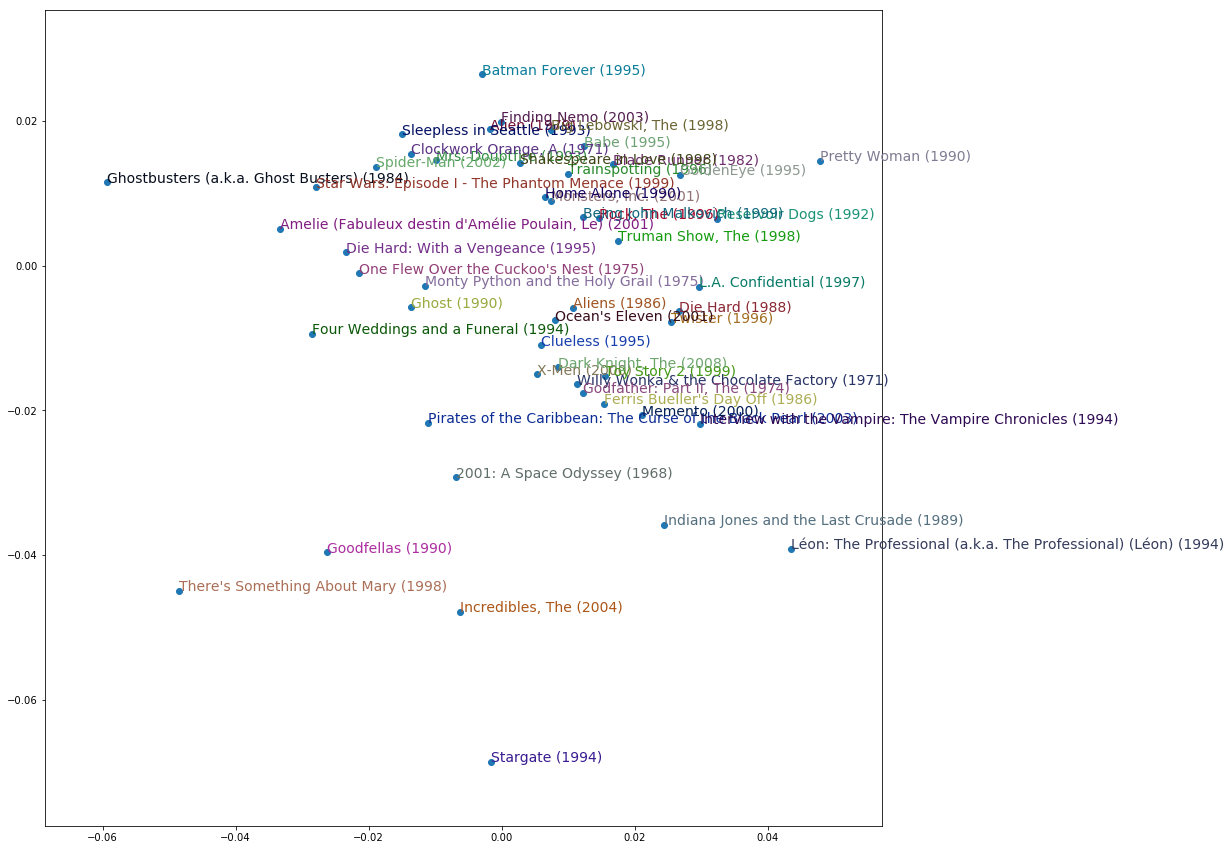

In [92]:
start=50; end=100
X = fac0[start:end]
Y = fac1[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

## Exercícios

1. Inclua um novo usuário, sem nenhuma avaliação. Treine a rede e verifique
   se após a rede treinada, se haverá alguma avaliação.
2. Com o novo usuário, faça uma única avaliação e verifique quais os 10 filmes
   mais recomendados para ele.

## Aprendizados com este notebook